In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import itertools

from distutils.version import StrictVersion
from tensorflow.python.platform import gfile
from tensorflow.core.protobuf import saved_model_pb2
from tensorflow.python.util import compat
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from os import listdir
from os.path import isfile, join


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

In [3]:
%matplotlib inline

In [4]:
#Object detection imports
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.dataset_tools import create_coco_tf_record
from object_detection.inference import deetection_inference

object_detection/utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ahmed/Temp/p2_coco/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ahmed/Temp/p2_coco/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ahmed/Temp/p2_coco/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  Fi

In [5]:

# What model to download.
MODEL_NAME = 'faster_rcnn_resnet101_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

LOGDIR= MODEL_NAME + '/logs'
NUM_CLASSES = 90

In [6]:

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [8]:
#Loading label map
path="/home/ahmed/Temp/models/research/object_detection"
os.chdir(path)
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
#Helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
    (im_height, im_width, 3)).astype(np.uint8)

In [10]:
#Detection
PATH_TO_TEST_IMAGES_DIR = "/home/ahmed/Temp/cocoapi/images/samples"
TEST_IMAGE_PATHS = [f for f in listdir(PATH_TO_TEST_IMAGES_DIR) if isfile(join(PATH_TO_TEST_IMAGES_DIR, f))]
IMAGE_SIZE = (12, 8)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
     
      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})      
      
      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict



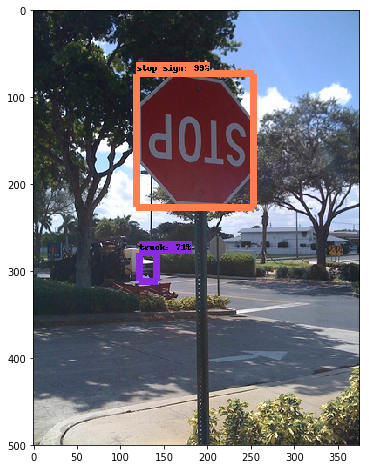

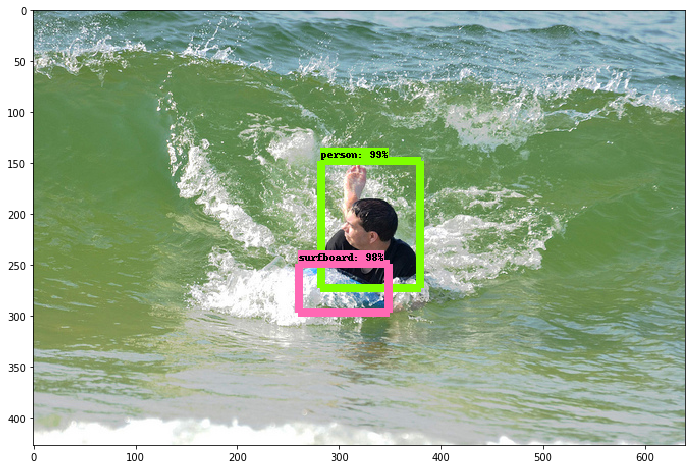

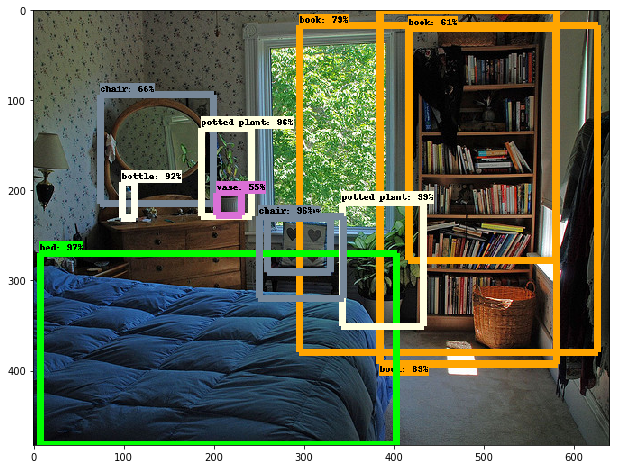

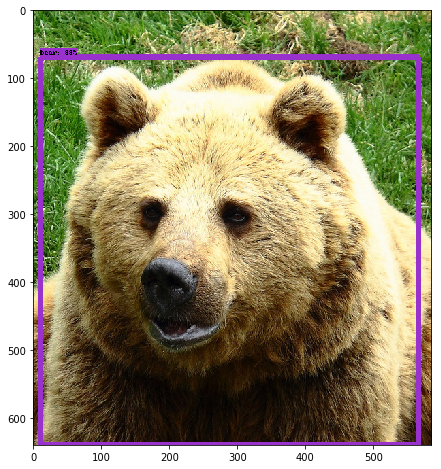

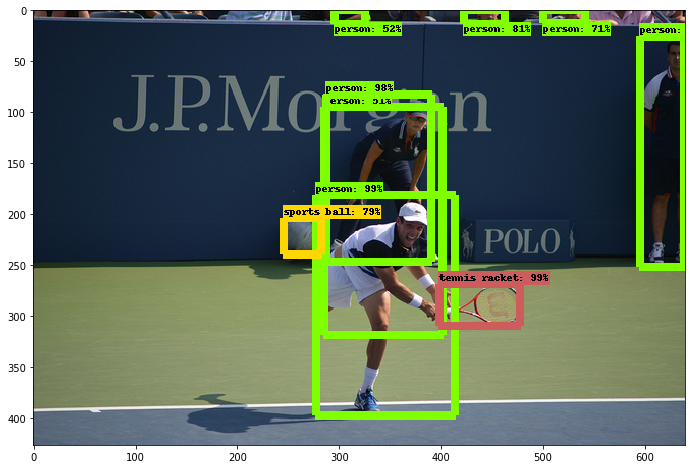

In [12]:
#for image_path in TEST_IMAGE_PATHS:

#if (len(TEST_IMAGE_PATHS) > 1):
  #image_path = TEST_IMAGE_PATHS[0]
  #image = Image.open(join(PATH_TO_TEST_IMAGES_DIR, image_path))
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(join(PATH_TO_TEST_IMAGES_DIR, image_path))
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict= run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  #print (num_detect)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)

  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  #print (output_dict['detection_boxes'])
   #print (output_dict.get('detection_masks'))

In [13]:
import time
import json

total_time = 0.0;
grbboxes_filenames=[]
img_bbox_ids=[]
filename_img_bbox_ids=[]

def gr_bbox():
    json_filename="/home/ahmed/Temp/cocoapi/annotations/instances_val2017.json"
    array=[]
    try:
        with open(json_filename) as data_file:
            data=json.load(data_file)
            img_height=0
            img_width=0
            for each_axis in data['images']:
                img_height = each_axis['height']
                img_width = each_axis['width']
                img_filename = each_axis['file_name']
                grbboxes_filenames.append(img_filename)
                image_id = each_axis['id']
                filename_img_bbox_ids.append(image_id)
                
            if len(grbboxes_filenames) != len(filename_img_bbox_ids):
                print ("these 2 should be the same length")
            
            for each_axis in data['annotations']:
                image_id =  each_axis['image_id']
                img_bbox_ids.append(image_id)
                X = each_axis['bbox']
                if image_id == 285:
                    #print ("img id", image_id)
                    print ("bbox", X)
                tmp_bb=[0, 0, 0, 0]
                #tmp_bb[0]=X[2]/img_height
                #tmp_bb[1]=X[3]/img_width
                #tmp_bb[2]=X[0]/img_height
                #tmp_bb[3]=X[1]/img_width
                tmp_bb[0]=X[0]/img_width
                tmp_bb[1]=X[1]/img_height
                tmp_bb[2]=tmp_bb[0]+(X[2]/img_width)
                tmp_bb[3]=tmp_bb[1]+(X[3]/img_height)
                X=tmp_bb
                if image_id == 285:
                    print ("bbox normalized", X)
                array.append(X)
                
            if len(img_bbox_ids) != len(array):
                print ("These 2 should also have same length")
                
    except:
        print("Unexpected error", sys.exc_info()[0])
        raise
        
    gr_bboxes = list()
    #max_coord=np.max(array)
    for bbox in array:
        #print (bbox)
        #bbox = [x/max_coord for x in bbox[:4]]
        #bbox = [x for x in bbox[:4]]
        #bbox = [x/256 for x in bbox[:4]]
        gr_bboxes.append(bbox)
        
    return gr_bboxes
        
gr_bboxes = gr_bbox()



('bbox', [1.43, 68.81, 584.57, 563.94])
('bbox normalized', [0.002234375, 0.14335416666666667, 0.9156250000000001, 1.3182291666666668])


In [14]:
def find_img_id(img_filename):
    countl=0
    for filen in grbboxes_filenames:
        if img_filename == filen:
            return countl
        countl = countl + 1
        
    return -1


In [15]:

def bb_IOU(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = np.maximum(xB - xA, 0) * np.maximum(yB - yA, 0)
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs(boxA[2] - boxA[0]) * abs(boxA[3] - boxA[1])
    boxBArea = abs(boxB[2] - boxB[0]) * abs(boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def get_iou(pred_bboxes,gr_bboxes,img_id_to_check):
    iou=0
    
    for pred_box in pred_bboxes:  
        for gr_box in gr_bboxes: 
            #print ("this is one pred box")
            #print (pred_box)
            #print ("this is one gr_box")
            #print (gr_box)                
            iou = bb_IOU(pred_box, gr_box)  
            if iou > 0.5:
                print ("IOU is")
                print (iou)
                return iou
    
    return iou



def get_r_boxes_single_imag(image_path,img_id):
     
    """Function to get the Ground truth boxes for a specific image

     Args:
     image_path: path for the image to get the ground truth boxes for
     img_id    : Image ID, incase it's already stored in the system

     Return
    gr_bboxes_update: truth boxes and their co-ordinates (normalized)
    
    """
    #json_filename="/home/ahmed/Temp/cocoapi/annotations/instances_val2017.json"
    array=[]
    #try:
     #   with open(json_filename) as data_file:
      #      data=json.load(data_file)
    img_height=0
    img_width=0
    for each_axis in data['images']:
        if image_path == each_axis['file_name']:
             # Get the Images dimension
                    img_height = each_axis['height']
                    img_width = each_axis['width']
                    imge_id = each_axis['id']
   
    for each_axis in data['annotations']:
                if imge_id == each_axis['image_id']:
                    X = each_axis['bbox']
                    
                    tmp_bb=[0, 0, 0, 0]
                    tmp_bb[0]=X[0]/img_width
                    tmp_bb[1]=X[1]/img_height
                    tmp_bb[2]=tmp_bb[0]+X[2]/img_width
                    tmp_bb[3]=tmp_bb[1]+X[3]/img_height
                    X=[tmp_bb[1],tmp_bb[0],tmp_bb[3],tmp_bb[2]]
                    
                    array.append(X)
                    
  #  except:
   #     print("Unexpected error", sys.exc_info()[0])
    #    raise              

        
    gr_bboxes_update = list()
    
    for bbox in array:
         gr_bboxes_update.append(bbox)
   
    

    return gr_bboxes_update
    
 



In [16]:
iou_out = list()
pred_bboxes = 0
gr_found=0
count2=0

json_filename="/home/ahmed/Temp/cocoapi/annotations/instances_val2017.json"
try:
        with open(json_filename) as data_file:
            data=json.load(data_file)
except:
            print("Unexpected error", sys.exc_info()[0])
            raise
#mylp = [TEST_IMAGE_PATHS[0]]
for image_path in TEST_IMAGE_PATHS:
#for image_path in mylp:
    image = Image.open(join(PATH_TO_TEST_IMAGES_DIR, image_path)) 
    print ("Processing image ")
    print (image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    t1 = time.time()
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    pred_bboxes += output_dict['num_detections']
    
     
    loc=find_img_id(image_path)
    if loc==-1:
        print ("index was found to be -1 , something wrong")
    print ("Processing img with ID")
    img_id_to_check=filename_img_bbox_ids[loc]
    print (img_id_to_check)
    #get the Ground truth boxes for this image
    gr_boxes=get_r_boxes_single_imag(image_path,img_id_to_check)
    gr_found+=len(gr_boxes)       
    for mybbox in output_dict['detection_boxes']:
        
            list1 = []
            list1.append(mybbox)
            iou=get_iou(list1, gr_boxes,img_id_to_check)
            if iou > 0.5: # count any coverage
                iou_out.append(iou)
            
            t2 = time.time()
            #print("time ", t2 - t1)
            total_time += (t2 - t1)
            count2 = count2 + 1
        
    print('mean time=')
    print(total_time/count2)
    
MIOU=sum(iou_out)/len(iou_out)*100
precision=gr_found/pred_bboxes
print("MIOU is")
print(MIOU)
print('*'*40)
print ("Model was right that many times")
print(len(iou_out))
print ("Total predicted boxes")
print (pred_bboxes)
print ("Total gt boxes")
print(gr_found)
print("The precision score is:")
print(precision)
print('*'*40)

Processing image 
000000000724.jpg
Processing img with ID
724
IOU is
0.9566845807349661
IOU is
0.7513428133390276
mean time=
6.40640047312
Processing image 
000000002261.jpg
Processing img with ID
2261
IOU is
0.9383753016242938
IOU is
0.8867922906412797
mean time=
6.45903824329
Processing image 
000000000632.jpg
Processing img with ID
632
IOU is
0.8586683509845041
IOU is
0.9329702524870443
IOU is
0.8748074620156232
IOU is
0.8630302715153262
mean time=
6.4777092131
Processing image 
000000000285.jpg
Processing img with ID
285
IOU is
0.9382572034954452
mean time=
6.50107448637
Processing image 
000000000885.jpg
Processing img with ID
885
IOU is
0.9437345540673058
IOU is
0.9054864224438443
IOU is
0.9638105494634125
IOU is
0.8271990863273361
IOU is
0.6073479649031345
IOU is
0.5001445135227823
IOU is
0.6486577625923898
IOU is
0.6406405721079647
mean time=
6.50425368023
MIOU is
82.5761761897981
****************************************
Model was right that many times
17
Total predicted boxes


In [17]:
#Change the data input format from images and annonation (json) to TF records format
# path to import the jason file
json_filename="/home/ahmed/Temp/cocoapi/annotations/instances_val2017.json"
#Path to where the Tf files will be stored
output_path="/home/ahmed/Temp/cocoapi/annotations/tfrecord/out.record"
#Path to the image directory
imag_dir="/home/ahmed/Temp/cocoapi/images/val2017"
#Num of output files (will keep it 1 for now)
num_data_files=1
create_coco_tf_record._create_tf_record_from_coco_annotations(json_filename, imag_dir, output_path,False,num_data_files)



INFO:tensorflow:Found groundtruth annotations. Building annotations index.
INFO:tensorflow:48 images are missing annotations.
INFO:tensorflow:On image 0 of 5000
INFO:tensorflow:On image 100 of 5000
INFO:tensorflow:On image 200 of 5000
INFO:tensorflow:On image 300 of 5000
INFO:tensorflow:On image 400 of 5000
INFO:tensorflow:On image 500 of 5000
INFO:tensorflow:On image 600 of 5000
INFO:tensorflow:On image 700 of 5000
INFO:tensorflow:On image 800 of 5000
INFO:tensorflow:On image 900 of 5000
INFO:tensorflow:On image 1000 of 5000
INFO:tensorflow:On image 1100 of 5000
INFO:tensorflow:On image 1200 of 5000
INFO:tensorflow:On image 1300 of 5000
INFO:tensorflow:On image 1400 of 5000
INFO:tensorflow:On image 1500 of 5000
INFO:tensorflow:On image 1600 of 5000
INFO:tensorflow:On image 1700 of 5000
INFO:tensorflow:On image 1800 of 5000
INFO:tensorflow:On image 1900 of 5000
INFO:tensorflow:On image 2000 of 5000
INFO:tensorflow:On image 2100 of 5000
INFO:tensorflow:On image 2200 of 5000
INFO:tensorf

In [ ]:
#Read the input from tf_records 
input_tfrecord_paths="/home/ahmed/Temp/cocoapi/annotations/tfrecord/out.record-00000-of-00001"
input_tfrecord_paths = [v for v in input_tfrecord_paths.split(',') if v]
tf.logging.info('Reading input from %d files', len(input_tfrecord_paths))
serialized_example_tensor, image_tensor = deetection_inference.build_input(input_tfrecord_paths)
detected_boxes_tensor, detected_scores_tensor, detected_labels_tensor=deetection_inference.build_inference_graph(image_tensor, od_graph_def)


#Runs the supplied tensors and adds the inferred detections to the example.
tf_example= deetection_inference.infer_detections_and_add_to_example(serialized_example_tensor, detected_boxes_tensor, detected_scores_tensor,detected_labels_tensor,False)

INFO:tensorflow:Reading input from 1 files
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordData